/Users/sourguyxian/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:103: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


PACKER vs Hierarchical Sampling With Representativeness
	Pearson  r   = 0.782 95%CI[0.657,0.890], p = 7.62e-08
	Spearman rho = 0.735 95%CI[0.471,0.868], p = 1.11e-06


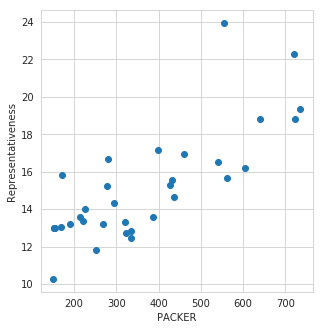

In [7]:
#Scatterplots of each model's fit to the dataset. 
import pickle, math
import pandas as pd
import sqlite3
import random
execfile('Imports.py')
import Modules.Funcs as funcs
from Modules.Classes import Simulation
from Modules.Classes import CopyTweak
from Modules.Classes import CopyTweakRep
from Modules.Classes import Packer
from Modules.Classes import PackerRep
from Modules.Classes import ConjugateJK13
from Modules.Classes import RepresentJK13
from scipy.stats import stats as ss
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

pearson = True
fittype = 'corr' #corr,e1e2,catassign
if pearson:
    corrtype = 'p'
else:
    corrtype = 's'
#Bootstrap parameters
nbootstraps = 1000

#Include only lls more than 150?
include150 = True

if fittype is 'corr':
    bestparmdb = "pickles/chtc_gs_best_params_corr{}.p".format(corrtype)#"pickles/chtc_gs_best_params_all_data_e1_e2.p"#"pickles/chtc_gs_best_params_corr{}.p".format(corrtype)
    modeleaseDB = "pickles/modelease_corr{}.p".format(corrtype)
elif fittype is 'catassign':
    bestparmdb = "pickles/chtc_gs_best_params_catassign.p"
    modeleaseDB = ''    
elif fittype is 'e1e2':
    bestparmdb = "pickles/chtc_gs_best_params_all_data_e1_e2.p"
    modeleaseDB = ''

savefilename='modelvsmodel scatterplots/{}fits_modelvsmodel{}_tt.pdf'.format(fittype,corrtype)


#Some plotting options
font = {'family' : 'DejaVu Sans',
        'weight' : 'regular',
        'size'   : 10}
show_p = False #show pearson r in plots
show_s = False #show spearman tho in plots

#Specify simulation values
N_SAMPLES = 10000
WT_THETA = 1.5
MIN_LL = 1e-10

# Specify default dataname
dataname_def = 'midbot'#'nosofsky1986'#'NGPMG1994'
participant_def = 'all'
unique_trials_def = 'all'
dataname = dataname_def
execfile('validate_data.py')


plt.rc('font', **font)

# get data from pickle
with open(pickledir+src, "rb" ) as f:
    trials = pickle.load( f )

# get best params pickle
#bestparmdb = "pickles/chtc_gs_best_params_all_data_e1_e2.p"
#bestparmdb = "pickles/chtc_gs_best_params_corrs.p"
with open(bestparmdb, "rb" ) as f:
    best_params_t = pickle.load( f )

#Rebuild it into a smaller dict
best_params = dict()
for modelname in best_params_t.keys():    
    best_params[modelname] = dict()
    for i,parmname in enumerate(best_params_t[modelname]['parmnames']):
        parmval = best_params_t[modelname]['bestparmsll']
        best_params[modelname][parmname] = parmval[i]
modelList = [Packer,RepresentJK13]#[Packer,CopyTweak,ConjugateJK13,RepresentJK13]
#modelList = [CopyTweak,CopyTweakRep,Packer, RepresentJK13,]                            

#Specify plot order
# modelPlotOrder = np.array([[Packer,RepresentJK13],[CopyTweak,ConjugateJK13]])
#modelPlotOrder = np.array([[CopyTweak,CopyTweakRep],[Packer,RepresentJK13]])

#Prepare matched database    
matchdb='../cat-assign/data_utilities/cmp_midbot.db'
        
unique_trials = 'all'
trials.task = task

#Get learning data
data_assign_file = '../cat-assign/data/experiment.db'
con = sqlite3.connect(data_assign_file)
info = pd.read_sql_query("SELECT * from participants", con)
assignment = pd.read_sql_query("SELECT * FROM assignment", con)
stimuli = pd.read_sql_query("SELECT * from stimuli", con).as_matrix()
con.close()
#Get generation data
data_generate_file = 'experiment-midbot.db'
con = sqlite3.connect(data_generate_file)
stats = pd.read_sql_query("SELECT * from betastats", con)
con.close()

#Get unique ppts
pptlist = []#np.array([]);
for i,row in info.iterrows():
    pptlist += [row.pptmatch]
        #    pptlist = np.concatenate((pptlist,trial['participant']))

#Specify a few more bootstrap parameters
nsamples = len(pptlist)
nsamprange = range(nsamples)


pptlist = np.unique(pptlist)
#see if ll_global exists as a pickle, otherwise construct new ll
ll_loadSuccess = {}
for model in modelList:
    ll_loadSuccess[model.model] = False
    
try:
    with open(modeleaseDB, "rb" ) as f:
        ll_global = pickle.load( f )
        #Check that model name exists in global, otherwise run it again
        for model in modelList:
            if model.model in ll_global.keys():
                ll_loadSuccess[model.model] = True
except:
    ll_global = dict()
    #ll_loadSuccess = False
    
# options for the optimization routine
options = dict(
    method = 'Nelder-Mead',
    options = dict(maxiter = 500, disp = False),
    tol = 0.01,
) 


#Prepare corr var
if 'tso' not in ll_global.keys():
    pptdata,tso = funcs.prep_corrvar(info,assignment,stimuli,stats,WT_THETA)
    ll_global['tso'] = tso
    ll_global['pptdata'] = pptdata
else:
    tso = ll_global['tso']

for model_obj in modelList:
    #model_obj = Packer
    model_name = model_obj.model
    if not ll_loadSuccess[model_name]:
        #Get log likelihoods
        ll_list = []
        print_ct = 0
        for ppt in pptlist:
            #since info contains the new mapping of ppts, and pptlist contains old,
            #convert ppt to new
            pptNew = ppt #
            pptOld = funcs.getMatch(pptNew,matchdb,fetch='Old')    
            pptloc = info['pptmatch']==pptNew
            #Get alphas with an ugly line of code
            As_num  = eval(info['stimuli'].loc[pptloc].as_matrix()[0])[0:4];
            As = stimuli[As_num,:]
            params  = best_params[model_name]
            pptcondition = info['condition'].loc[pptloc].as_matrix()[0];
            pptbeta = eval(info['stimuli'].loc[pptloc].as_matrix()[0])[4:8];
            nstim = len(pptbeta);    
            #Get weights
            ranges = stats[['xrange','yrange']].loc[stats['participant']==pptOld]
            params['wts'] = funcs.softmax(-ranges, theta = WT_THETA)[0]
            if model_obj ==  ConjugateJK13 or model_obj == RepresentJK13:
                params['wts'] = 1.0 - params['wts']
            #transform parms
            model = model_obj([As], params)
            params = model.parmxform(params, direction = 1)
            
            # Get all permutations of pptbeta and make a new trialObj for it
            nbetapermute = math.factorial(nstim)
            betapermute = [];
            raw_array = np.zeros((1,nbetapermute))
            categories = [As_num,pptbeta]
            #Get loglikelihoods
            raw_array_ll = Simulation.loglike_allperm(params, model_obj, categories, stimuli, permute_category = 1)
            ll_list += [raw_array_ll]
            #print categories,raw_array_ll
            print_ct = funcs.printProg(ppt,print_ct,steps = 1, breakline = 20, breakby = 'char')

        #Re-organise the lists
        ll_list = np.atleast_2d(ll_list)
        pptlist2d = np.atleast_2d(pptlist)
        ll = np.concatenate((pptlist2d,ll_list),axis=0).T

        #sort
        ll = ll[ll[:,1].argsort()]
        #Add third col of zeros
        ll = np.concatenate((ll,np.atleast_2d(np.zeros(len(ll))).T),axis=1)    
    
        #attach ppt errors
        #         for i, row in info.iterrows():
        #             #fh, ax = plt.subplots(1,2,figsize = (12,6))
        #             ppt  = row.participant
        #             pptAssign = assignment.loc[assignment['participant']==ppt].sort_values('trial')
        #             nTrials = len(pptAssign)
        #             accuracyEl = float(sum(pptAssign.correctcat == pptAssign.response))/nTrials


        #             pptNew = row.pptmatch
        #             #Prepare to plot configuration
        #             #get matched data
        #             #matched = funcs.getMatch(pptmatch,matchdb)
        #             #Add participant mean error to ll matrix
        #             ll[ll[:,0]==pptNew,2] = 1-accuracyEl
        
        ll_global[model_name] = ll
        
        #Save pickle for faster running next time
#         with open(modeleaseDB, "wb" ) as f:
#             pickle.dump(ll_global, f)
            
#Make list of pairwise comparison indices
if len(modelList)>2:
    pairwise = [[x,y] for x in range(len(modelList)) for y in range(len(modelList))]
    fh,axs = plt.subplots(len(modelList),len(modelList), figsize=(15,15))
else:
    pairwise = [[0,1]]
    fh,axs = plt.subplots(1,1, figsize=(5,5))
#Prepare correlations and plot
#fh,axs = plt.subplots(2,int(np.ceil(len(modelList)/2)), figsize=(20,8))

plt.tight_layout(w_pad=1,h_pad=5.0,rect=(.05,.05,.95,.95))
lle = []
for m,models01 in enumerate(pairwise):
#     model_loc = modelPlotOrder==model_obj
    if len(modelList)>2:
        ax = axs[models01[0]][models01[1]]
    else:
        ax = axs
    model0_obj = modelList[models01[0]]    
    model0_name = model0_obj.model
    model0_print = model0_obj.modelprint

    model1_obj = modelList[models01[1]]
    model1_name = model1_obj.model
    model1_print = model1_obj.modelprint
                
    #copy entire structure for first model 
    ll = ll_global[model0_name].copy()
    ll1 = ll_global[model1_name].copy()
    
    if include150:
        #Separate hi-low lls
        lle = ll[ll[:,1]<150,:]
        ll = ll[ll[:,1]>=150,:]
    #Specify a few more bootstrap parameters
    nsamples = ll.shape[0]
    nsamprange = range(nsamples)
    
    #Then insert only lls for second model into third column (for legacy reasons, the third column is participant errors, which we don't need here)
    for ii,row in enumerate(ll):
        pid = row[0]
        ll_insert = ll1[ll1[:,0]==pid,1]
        ll[ii,2] = ll_insert       
    #ll[:,2] = ll_global[model1_name][:,1].copy()
    #Get correlations
    corr_p = ss.pearsonr(ll[:,1],ll[:,2])
    corr_s = ss.spearmanr(ll[:,1],ll[:,2])
    cov = np.cov(ll[:,1],ll[:,2])
    #Run bootstrap
    corr_bs_p = []
    corr_bs_s = []
    bestfitlines = []
    if not pearson:
        rankorderx_base = np.array(range(len(ll[:,1])))
        rankordery_base = ll[:,2].argsort()
    for bsi in range(nbootstraps):
        bs_samples = [random.choice(nsamprange) for ct in nsamprange]
        ll_bs = ll[bs_samples,:]
        corr_bs_p += [ss.pearsonr(ll_bs[:,1],ll_bs[:,2])[0]]            
        corr_bs_s += [ss.spearmanr(ll_bs[:,1],ll_bs[:,2])[0]]
        if pearson:
            #Find best fit line        
            bscoeff = np.polyfit(ll_bs[:,1],ll_bs[:,2],1)
            xrange_bs = np.linspace(min(ll[:,1]),max(ll[:,1]),100)
        else:
            rankorderx = rankorderx_base[bs_samples]            
            rankordery = rankordery_base[bs_samples]
            #Add best fit line
            bscoeff = np.polyfit(rankorderx,rankordery,1)
            xrange_bs = np.linspace(min(rankorderx),max(rankorderx),100)            
        bestfitlines += [bscoeff]
    #Get upper and lower 95% percentile of y at each x
    yrangeLL = []
    yrangeUL = []
    for xi in xrange_bs:
        yrangeAll = [xi*bfl[0] + bfl[1] for bfl in bestfitlines]
        yrangePct = np.percentile(yrangeAll,(2.5, 97.5))
        yrangeLL += [yrangePct[0]]
        yrangeUL += [yrangePct[1]]
#     ax.plot(xrange_bs,yrangeUL,'g:')
#     ax.plot(xrange_bs,yrangeLL,'g:')
    
    #Get 95% CI
    ci_95_p = np.percentile(corr_bs_p,(2.5, 97.5))
    ci_95_s = np.percentile(corr_bs_s,(2.5, 97.5))
        
    print('%s vs %s' % (model0_name,model1_name))
    print('\tPearson  r   = {:.3f} 95%CI[{:.3f},{:.3f}], p = {:.2e}'.format(
        corr_p[0],ci_95_p[0],ci_95_p[1],corr_p[1]))
    #print '\tp = ' + str(corr[1])
    print '\tSpearman rho = {:.3f} 95%CI[{:.3f},{:.3f}], p = {:.2e}'.format(
        corr_s[0],ci_95_s[0],ci_95_s[1],corr_s[1])
    #Plot figure
    if pearson:
        ax.scatter(ll[:,1],ll[:,2])
        #Add best fit line
#         coeff = np.polyfit(ll[:,1],ll[:,2],1)
#         x = np.array([min(ll[:,1]),max(ll[:,1])])
#         y = x*coeff[0] + coeff[1]
        #Find ideal position for text
        xrange = ax.get_xlim()
        textx = (xrange[1]-xrange[0])*.1+xrange[0]
        texty = .62
        #Specify axis label strings
        xlabel = model0_print
        ylabel = model1_print
    else:
        rankorderx = range(len(ll[:,1]))
        rankordery = ll[:,2].argsort()
        ax.scatter(rankorderx,rankordery)
        #Add best fit line
#         coeff = np.polyfit(rankorderx,rankordery,1)
#         x = np.array([min(rankorderx),max(rankorderx)])
#         y = x*coeff[0] + coeff[1]

        #Find ideal position for text
        xrange = ax.get_xlim()
        yrange = ax.get_ylim()
        textx = (xrange[1]-xrange[0])*.1+xrange[0]
        texty = (yrange[1]-yrange[0])*.85+yrange[0]
        xlabel = model0_print
        ylabel = model1_print
        #Add line of equal rank        
        ax.plot(xrange,yrange,'--')
        
    #Format presentation of correlation values
    if show_p:
        titlestr_p = 'r = {:.3}, p = {:.2e}'.format(corr_p[0],corr_p[1])
    else:
        titlestr_p = ''
    if show_s:        
        rho = r'$\rho$'
        titlestr_s = '{} = {:.3}, p = {:.2e}'.format(rho,corr_s[0],corr_s[1])
    else:
        titlestr_s = ''
    if show_p and show_s:
        titlestr_all = '{}\n{}'.format(titlestr_p,titlestr_s)
    else:
        if show_p:
            titlestr_all = '{}'.format(titlestr_p)
        elif show_s:
            titlestr_all = '{}'.format(titlestr_s)
        else:
            titlestr_all = ''
    ax.text(textx,texty,titlestr_all,fontsize=6)
#     ax.plot(x,y,'--')
#     ax.set_title(model_print0)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    #ax.set_title('{}\n{}'.format(titlestr_p, titlestr_s),fontsize=12)
    #ax.set_xlabel('negLL\n{}'.format(model_print))
#     first_col = np.where(model_loc)    

#     if models01[0]==0:
#         ax.set_xlabel(xlabel)
# #         ax.set_ylabel(ylabel)
#     else:
#         ax.set_xlabel('')
#         ax.set_ylabel('')
#         ax.set_yticklabels([])
    
# plt.savefig(savefilename)
# plt.cla()

#Also print the likelihood ratio test results for PACKER vs CopyTweak
# This is simply -2(LL_Packer - LL_CopyTweak)
#280618  - ok likelihood ratio test doesn't seem to make sense. Run bootstrap instead.
#Get global generation LL using these parameters
# global_ll_packer = trials.loglike(best_params['PACKER'],Packer,parmxform=False)
# global_ll_copytweak = trials.loglike(best_params['Copy and Tweak'],CopyTweak,parmxform=False)

# from scipy import stats as s2
# ll_ratio = -2.0 * (global_ll_packer - global_ll_copytweak)
# pval = s2.chi2.sf(ll_ratio,1);

# print "Likelihood ratio test:"
# print "\t chi_sq (1) = {}, p = {:.3}".format(ll_ratio,pval)




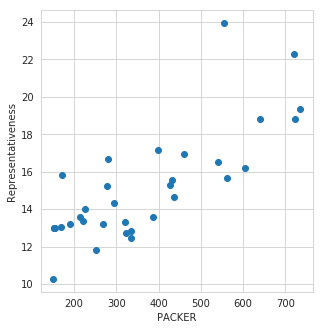

In [8]:
fh

In [91]:
fh.savefig(savefilename)

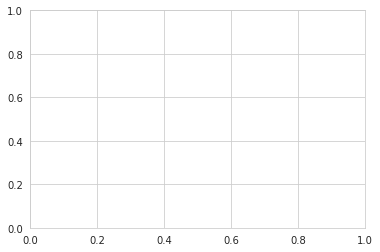

In [64]:
fhh,axt = plt.subplots(1,1)

In [9]:
ll


array([[ 26.        , 150.83587876,  10.27877133],
       [121.        , 151.34231714,  13.00832737],
       [112.        , 151.34231714,  13.00832737],
       [ 95.        , 155.50749638,  12.97989667],
       [ 32.        , 169.90850935,  13.04267786],
       [ 89.        , 171.0750412 ,  15.83626935],
       [ 85.        , 189.44772195,  13.19505467],
       [ 38.        , 213.68791723,  13.57413775],
       [  6.        , 220.01850275,  13.34284634],
       [114.        , 226.87330223,  13.99075241],
       [ 98.        , 252.26315068,  11.82857982],
       [  5.        , 267.39728507,  13.2284531 ],
       [ 72.        , 278.02340456,  15.24447012],
       [ 94.        , 280.53624646,  16.66442771],
       [ 17.        , 293.76601006,  14.34383132],
       [ 99.        , 321.67801652,  13.33305107],
       [ 54.        , 322.50806927,  12.74218454],
       [ 80.        , 333.8286277 ,  12.44996369],
       [ 51.        , 334.78574887,  12.82920604],
       [117.        , 386.59750

In [12]:
lle

array([[2.40000000e+01, 6.93147181e-01, 6.25000000e-02],
       [1.60000000e+01, 6.93147339e-01, 5.00000000e-01],
       [6.50000000e+01, 6.93147339e-01, 6.25000000e-02],
       [4.00000000e+00, 6.93147652e-01, 6.25000000e-02],
       [2.10000000e+01, 1.38629436e+00, 0.00000000e+00],
       [4.20000000e+01, 1.38629436e+00, 9.37500000e-02],
       [8.10000000e+01, 1.38629436e+00, 3.12500000e-02],
       [7.30000000e+01, 1.38629436e+00, 0.00000000e+00],
       [3.00000000e+00, 1.38629436e+00, 5.31250000e-01],
       [2.90000000e+01, 1.38629436e+00, 3.12500000e-02],
       [1.20000000e+02, 2.67543191e+00, 1.25000000e-01],
       [4.30000000e+01, 1.14702433e+01, 3.12500000e-02],
       [1.20000000e+01, 1.26982124e+01, 1.25000000e-01],
       [1.90000000e+01, 1.49745937e+01, 3.12500000e-02],
       [2.00000000e+00, 1.58824130e+01, 5.93750000e-01],
       [9.10000000e+01, 1.73775269e+01, 1.25000000e-01],
       [3.60000000e+01, 1.75321526e+01, 6.25000000e-02],
       [8.70000000e+01, 1.85354

In [13]:
len(lle)

69

In [ ]:
ll[ll[:,1]>150,0]

In [ ]:
a =2 

In [14]:
#Some indication of which model fits each data point better
ll

array([[ 26.        , 150.83587876,  10.27877133],
       [121.        , 151.34231714,  13.00832737],
       [112.        , 151.34231714,  13.00832737],
       [ 95.        , 155.50749638,  12.97989667],
       [ 32.        , 169.90850935,  13.04267786],
       [ 89.        , 171.0750412 ,  15.83626935],
       [ 85.        , 189.44772195,  13.19505467],
       [ 38.        , 213.68791723,  13.57413775],
       [  6.        , 220.01850275,  13.34284634],
       [114.        , 226.87330223,  13.99075241],
       [ 98.        , 252.26315068,  11.82857982],
       [  5.        , 267.39728507,  13.2284531 ],
       [ 72.        , 278.02340456,  15.24447012],
       [ 94.        , 280.53624646,  16.66442771],
       [ 17.        , 293.76601006,  14.34383132],
       [ 99.        , 321.67801652,  13.33305107],
       [ 54.        , 322.50806927,  12.74218454],
       [ 80.        , 333.8286277 ,  12.44996369],
       [ 51.        , 334.78574887,  12.82920604],
       [117.        , 386.59750